In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Define Input modality
- MR
- MR+clinic

In [3]:
MODALITY = "MR+clinic"

# Configurations

In [4]:
Configs = {
    "MR": {'mode': 'max', 'batch_size': 8, 'resolution': 420, 'pixelSize': 'min', 'label_name': 'CX', 'image_mode': 'only_lesion', 'gpu_id': '0', 'use_clinical': False},
    "MR+clinic": {'mode': 'max', 'batch_size': 8, 'resolution': 420, 'pixelSize': 'min', 'label_name': 'CX', 'image_mode': 'only_lesion', 'gpu_id': '0', 'use_clinical': True},
}

# Import modules

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import namedtuple, Counter
from train_utils import train_epoch, evaluate
import train_utils
from datasets import init_dataset
from i3d.i3res import inflated_resnet
from losses import FocalLoss
from utils import LR_Wramer
from sam import SAM
import cv2

In [6]:
config = Configs[MODALITY]
conf = namedtuple("config", config.keys())
args = conf(**config)

In [7]:
# for pretty text printing
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id
device = torch.device('cuda:0')

In [9]:
# GLOBAL VARS #
MODE = args.mode
N_EP = 25
USE_CLINICAL_DATA = args.use_clinical
ARCH = "R50"

In [10]:
def load_model(args, use_clinical=False, network_arch="I3ResNet"):
    clinical_indicator = "with_clinical" if use_clinical else "without_clinical"

    model_path = f'/data/Radiomics_model/{args.image_mode}/{args.pixelSize}/{args.label_name}/{network_arch}__{args.mode}__{clinical_indicator}__without_radiomics.pt'
    print(f"loaded weights from {model_path}!!!")
    net = torch.load(model_path)
    
    return net

In [11]:
def setup_convnet(args, loss="ce", use_dropout=False, class_weight=None, initial_bias=0.0):
    
    clinical_hidden = 64 if args.use_clinical else 0
    
    if USE_CLINICAL_DATA:

        # base CNN
        net = inflated_resnet(
            arch=ARCH, frame_nb=64, clinical_hidden=clinical_hidden)
        cls_inplaes = net.fc.in_features + clinical_hidden

        def init_mlp_weights(m):
            if type(m) == nn.Linear:
                torch.nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.01)

        net.clinical_mlp = torch.nn.Sequential(
                # clinical data dim = 3
                torch.nn.Linear(3, clinical_hidden),  
                torch.nn.LeakyReLU(0.02, True),
                torch.nn.Linear(clinical_hidden, clinical_hidden),
                torch.nn.LeakyReLU(0.02, True),
            )
        net.clinical_mlp.apply(init_mlp_weights)
            
        cls_inplaes = net.fc.in_features + clinical_hidden
    else:
        # base CNN
        net = inflated_resnet(
            arch=ARCH, frame_nb=64, clinical_hidden=clinical_hidden)
        cls_inplaes = net.fc.in_features + clinical_hidden
        
    classifier = []
    if use_dropout:
        if USE_CLINICAL_DATA:
            net.clinical_mlp = nn.Sequential(nn.Dropout(0.3), 
                                             *list(net.clinical_mlp))
        classifier.append(nn.Dropout(0.3))
        
    hidden = 256

    classifier.extend(
        [
            nn.Linear(cls_inplaes, hidden),
            nn.BatchNorm1d(hidden),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden, 2)
        ]
    )

    # replace cls layer
    net.fc = nn.Sequential(*classifier)
    
    for name, m in net.named_modules():
        if "fc" in name and isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, initial_bias)

    
    if loss == "ce":
        criterion = nn.CrossEntropyLoss(weight=class_weight)
    elif loss == "focal":
        criterion = FocalLoss(gamma=2.0, weight=class_weight)
        
    if torch.cuda.is_available():
        net.to(device)
        criterion.to(device)

    # optimizer and lr_scheduler
    if ARCH == "R50":
        lr = 1e-3 # for R50
    else:
        lr = 1e-4 # for shallower networks
        
    params = [{"params": net.fc.parameters()}]
    if getattr(net, "clinical_mlp", None):
        # use smaller lr
        params.append({"params": net.clinical_mlp.parameters(), "lr": 1e-3})
    
    net.train()
    for name, p in net.named_parameters():
        if p.requires_grad:
            print(name)
    base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
    optimizer = SAM(params, base_optimizer, lr=lr, momentum=0.9) # SAM Optimizer : Sharpness-Aware Minimization for Efficiently Improving Generalization; https://arxiv.org/abs/2010.01412
        
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer.base_optimizer,
                                                step_size = 5,
                                                gamma = 0.75)
    warmer = None # no lr warming

    return net, criterion, optimizer, scheduler, warmer

In [12]:
def seed_everything(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def get_class_weight(dataset):
    cnts = Counter(dataset.target_vals)
        
    pos = cnts['1']
    neg = cnts['0']

    total = len(dataset)
    weight_for_0 = (1 / neg)*(total)/2.0
    weight_for_1 = (1 / pos)*(total)/2.0
    class_weight = [weight_for_0, weight_for_1]

    return class_weight

In [13]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): Default: 7
            verbose (bool): Default: False
            delta (float): Default: 0
            path (str): checkpoint save path (Default: 'checkpoint.pt')
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        if not os.path.exists(path):
            os.system(f"mkdir -p {os.path.dirname(path)}")

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''save model when validation loss decrease'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, self.path)
        self.val_loss_min = val_loss

In [14]:
def get_statistical_initial_bias(dataset):
    cnts = Counter(dataset.target_vals)
    pos = cnts['1']
    neg = cnts['0']

    initial_bias = np.log(pos/neg)
    return initial_bias
    
def train(args, 
          loss="ce", 
          use_dropout=False,
          use_clinical=False,
          use_class_weight=False,
          epochs=20):
    
    # fix seed for reproducibilty
    seed_everything(seed=27)
    
    #### load dataset
    datasets, dataloaders = init_dataset(args)
    
    print()
    print('[Train] class counts', np.unique(
        datasets['train'].target_vals, return_counts=True))
    print('[Test] class counts', np.unique(
        datasets['test'].target_vals, return_counts=True))
    print()
    
    
    # initial bias considering statistics
    initial_bias = get_statistical_initial_bias(datasets['train'])
    
    # class weight to remedy data imbalance(default=False)
    class_weight = None
    if use_class_weight:
        class_weight = torch.FloatTensor(get_class_weight(datasets['train']))
        
    net, criterion, optimizer, scheduler, warmer = setup_convnet(args,
                                                                 loss=loss, 
                                                                 use_dropout=use_dropout, class_weight=class_weight,
                                                                 initial_bias=initial_bias)
    
    from collections import defaultdict
    learning_logs = {"loss": defaultdict(list), "auroc": defaultdict(list)}
    
    clinical_indicator = "with_clinical" if use_clinical else "without_clinical"
    savePath = f'/data/Radiomics_model/{args.image_mode}/{args.pixelSize}/{args.label_name}/{net.__class__.__name__}__{MODE}__{clinical_indicator}__without_radiomics.pt'
    
    # early stopping
    early_stopping = EarlyStopping(patience = 10, verbose = True, path=savePath)
    
    for ep in range(epochs):
        train_loss, train_auroc = train_epoch(net, dataloaders['train'], optimizer, warmer,
                    criterion, ep, scheduler=scheduler,
                    use_clinical=use_clinical)
        # evaluation with trainset with fixed image transform
        _, valid_loss, valid_auroc, best_ep = evaluate(net, dataloaders['test'], criterion,
                                 ep, use_clinical=use_clinical)
        
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(valid_auroc)
            
        learning_logs["loss"]["train"].append(train_loss)
        learning_logs["loss"]["val"].append(valid_loss)
        learning_logs["auroc"]["train"].append(train_auroc)
        learning_logs["auroc"]["val"].append(valid_auroc)
        
        # call early stopping
        early_stopping(valid_loss, net)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return net, criterion, dataloaders, best_ep, learning_logs

# Training model

In [15]:
##### print("#"*3, "Start training I3ResNet", "#"*3)
print()

# train 
net, criterion, dataloaders, best_ep, learning_logs = train(args, loss="focal",
                                             use_clinical=USE_CLINICAL_DATA,
                                             use_class_weight=True, 
                                             epochs=N_EP)



[Train] class counts (array(['0', '1'], dtype=object), array([129,  38]))
[Test] class counts (array(['0', '1'], dtype=object), array([66, 19]))

fc.0.weight
fc.0.bias
fc.1.weight
fc.1.bias
fc.3.weight
fc.3.bias
clinical_mlp.0.weight
clinical_mlp.0.bias
clinical_mlp.2.weight
clinical_mlp.2.bias
[Train] ep : 0 loss : 0.4508           acc : 0.4728 / SENS : 0.3684 / SPC : 0.5039 / PPV : 0.1795 / NPV : 0.7303 / f1 : 0.2414 / AUROC : 0.4357
[Test] ep : 0 loss : 0.3433           acc : 0.3591 / SENS : 0.8947 / SPC : 0.2121 / PPV : 0.2464 / NPV : 0.8750 / f1 : 0.3864 / AUROC : 0.6443
Validation loss decreased (inf --> 0.343280).  Saving model ...
[Train] ep : 1 loss : 0.1383           acc : 0.5986 / SENS : 0.8684 / SPC : 0.5194 / PPV : 0.3474 / NPV : 0.9306 / f1 : 0.4962 / AUROC : 0.7493
[Test] ep : 1 loss : 0.2068           acc : 0.6568 / SENS : 0.5789 / SPC : 0.6818 / PPV : 0.3438 / NPV : 0.8491 / f1 : 0.4314 / AUROC : 0.6595
Validation loss decreased (0.343280 --> 0.206785).  Saving model

[Train] ep : 24 loss : 0.0468           acc : 0.8435 / SENS : 0.8421 / SPC : 0.8450 / PPV : 0.6154 / NPV : 0.9478 / f1 : 0.7111 / AUROC : 0.9419
[Test] ep : 24 loss : 0.1651           acc : 0.7477 / SENS : 0.5789 / SPC : 0.8030 / PPV : 0.4583 / NPV : 0.8689 / f1 : 0.5116 / AUROC : 0.7927
EarlyStopping counter: 6 out of 10


# Testing  model

In [16]:
# load best model weights
net = load_model(args, use_clinical=USE_CLINICAL_DATA, network_arch="I3ResNet")


# evaluate with train_fixed
print()
print(bcolors.HEADER + "#"*3 +
      " Train Results with fixed image transform " + "#"*3)
train_eval_results, *_ = evaluate(net, dataloaders["train_fixed"], criterion,
         best_ep, use_clinical=USE_CLINICAL_DATA)
print(bcolors.ENDC)

# evaluate test results
print()
print(bcolors.WARNING + "#"*3 + " Test Results " + "#"*3)
test_eval_results, *_ = evaluate(net, dataloaders['test'], criterion,
         best_ep, use_clinical=USE_CLINICAL_DATA)
print(bcolors.ENDC)

loaded weights from /data/Radiomics_model/only_lesion/min/CX/I3ResNet__max__with_clinical__without_radiomics.pt!!!

### Train Results with fixed image transform ###
[Test] ep : 0 loss : 0.0234           acc : 0.9099 / SENS : 0.9737 / SPC : 0.8915 / PPV : 0.7255 / NPV : 0.9914 / f1 : 0.8315 / AUROC : 0.9878


### Test Results ###
[Test] ep : 0 loss : 0.1563           acc : 0.7364 / SENS : 0.7895 / SPC : 0.7273 / PPV : 0.4545 / NPV : 0.9231 / f1 : 0.5769 / AUROC : 0.7823



# Prepare analysis

In [17]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (10, 7)

In [18]:
clinical_indicator = "+clinical" if USE_CLINICAL_DATA else ""

save_dir = f"results/I3ResNet_MR{clinical_indicator}"
os.system("mkdir -p {}".format(save_dir))
print(save_dir)

results/I3ResNet_MR+clinical


# Factor analysis using SHAP analysis
- Aanalize importance of each clinical factor
- Tutorials
    - https://www.kaggle.com/ceshine/feature-importance-from-a-pytorch-model
    - https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
    - https://dodonam.tistory.com/221

loaded weights from /data/Radiomics_model/only_lesion/min/CX/I3ResNet__max__with_clinical__without_radiomics.pt!!!


100%|██████████| 11/11 [01:57<00:00, 10.72s/it]


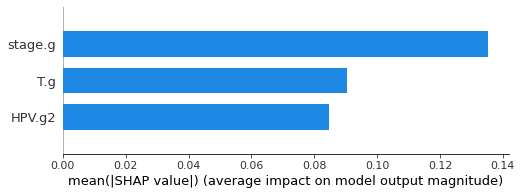

In [19]:
if USE_CLINICAL_DATA:
    import shap
    from tqdm import tqdm

    # load pre-trained weights
    pre_trained = load_model(args, use_clinical=USE_CLINICAL_DATA, network_arch="I3ResNet")

    test_loader = iter(dataloaders['test'])
    all_shap_values = []
    all_test_inputs = ([], [])

    class_of_interest = 1 # shap_values for positive class

    for _ in tqdm(range(len(test_loader))):
        test_input = next(test_loader)
        test_input = [ x.to(device) for x in test_input[:2] ]

        e = shap.DeepExplainer(model=pre_trained, data=test_input)
        shap_values = e.shap_values(test_input)

        all_shap_values.append(shap_values[class_of_interest][1])

        all_test_inputs[0].append(test_input[0].detach().cpu().numpy())
        all_test_inputs[1].append(test_input[1].detach().cpu().numpy())

    all_shap_values = np.concatenate(all_shap_values)
    all_test_inputs = list(all_test_inputs)

    all_test_inputs[0] = np.concatenate(all_test_inputs[0])
    all_test_inputs[1] = np.concatenate(all_test_inputs[1])

    plt.figure()

    feature_names = ["T.g", "stage.g", "HPV.g2"]
    
    shap.summary_plot(all_shap_values, 
                      features=all_test_inputs[1], 
                      feature_names=feature_names, plot_type="bar", show=False)
    plt.savefig(os.path.join(save_dir, f"factor_analysis_{ARCH}_{MODALITY}.png"), dpi=300, bbox_inches="tight")

# Loss history

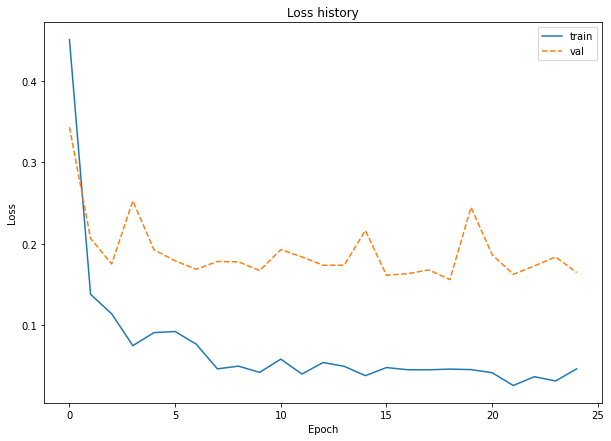

In [20]:
hist_loss = pd.DataFrame(learning_logs["loss"])
hist_loss.plot(style=["-", "--"], title="Loss history")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(os.path.join(save_dir, f"loss_history_{ARCH}_{MODALITY}.png"), dpi=300)

# Score history (AUROC)

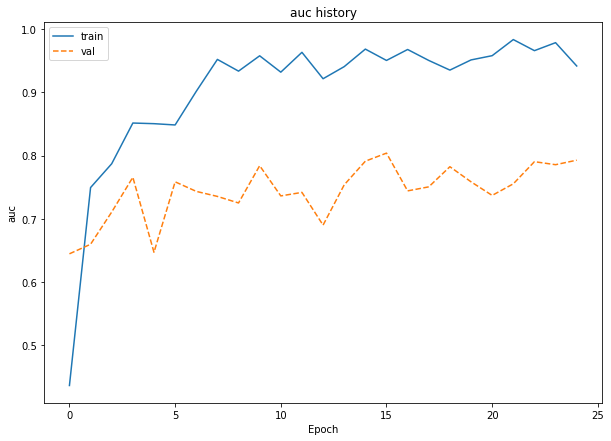

In [21]:
hist_auc = pd.DataFrame(learning_logs["auroc"])
hist_auc.plot(style=["-", "--"], title="auc history")
plt.xlabel("Epoch")
plt.ylabel("auc")
plt.savefig(os.path.join(save_dir, f"auc_history_{ARCH}_{MODALITY}.png"), dpi=300)

In [22]:
# loss
hist_loss.to_csv(os.path.join(save_dir, f"loss_history_{ARCH}.csv"), index=False)
# auc
hist_auc.to_csv(os.path.join(save_dir, f"auc_history_{ARCH}.csv"), index=False)

# Save evaluation file as .csv format

In [23]:
import copy

train_eval_results_copy = copy.copy(train_eval_results)
test_eval_results_copy = copy.copy(test_eval_results)

for k in train_eval_results_copy.keys():
    train_eval_results_copy[k] = train_eval_results[k].ravel().tolist()
for k in test_eval_results_copy.keys():
    test_eval_results_copy[k] = test_eval_results[k].ravel().tolist()
    
# save as .csv format
pd.DataFrame.from_dict(train_eval_results_copy).to_csv(os.path.join(save_dir, f"train_eval_results_{ARCH}.csv"), index=None)
pd.DataFrame.from_dict(test_eval_results_copy).to_csv(os.path.join(save_dir, f"test_eval_results_{ARCH}.csv"), index=None)

# Save evaluation results

In [24]:
import pickle

In [25]:
# train
with open(os.path.join(save_dir, f"train_eval_results_{ARCH}.pkl"), "wb") as f:
    pickle.dump(train_eval_results, f)

# test
with open(os.path.join(save_dir, f"test_eval_results_{ARCH}.pkl"), "wb") as f:
    pickle.dump(test_eval_results, f)

# Load evaluation results

In [26]:
import pickle

# load evaluation results
with open(os.path.join(save_dir, f"train_eval_results_{ARCH}.pkl"), "rb") as f:
    train_eval_results = pickle.load(f)

with open(os.path.join(save_dir, f"test_eval_results_{ARCH}.pkl"), "rb") as f:
    test_eval_results = pickle.load(f)    

# Result analysis

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [28]:
def draw_roc(res, legend=None, point_color=None, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    fpr, tpr, thresh = metrics.roc_curve(res['y_test'], res['y_score'][:,0])

    roc_auc = metrics.auc(fpr, tpr)
    
    lw = 2
    ax.plot(1-fpr, tpr, "-", color=point_color,
             lw=lw, label=f'{legend} (AUC = {roc_auc:.4f})' if legend else None)
    ax.plot([1, 0], [0, 1], color='gray', lw=lw, linestyle='--')
    ax.set_xlim([1.05, -0.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Specificity')
    ax.set_ylabel('Sensitivity')
    if title is not None:
        ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(True)
    plt.tight_layout()

In [29]:
def read_history_file(use_clinical_data):
    clinical_indicator = "+clinical" if use_clinical_data else ""

    save_dir = f"results/I3ResNet_MR{clinical_indicator}"
    
    name = os.path.basename(save_dir)
    print(save_dir)
    # load history files
    hist_loss = pd.read_csv(os.path.join(save_dir, f"loss_history_{ARCH}.csv"))
    hist_auc  = pd.read_csv(os.path.join(save_dir, f"auc_history_{ARCH}.csv"))
    
    return name, hist_loss, hist_auc

In [30]:
def read_evaluation_file(use_clinical_data):
    clinical_indicator = "+clinical" if use_clinical_data else ""

    save_dir = f"results/I3ResNet_MR{clinical_indicator}"
    
    name = os.path.basename(save_dir)
    
    # load evaluation results
    with open(os.path.join(save_dir, f"train_eval_results_{ARCH}.pkl"), "rb") as f:
        train_results = pickle.load(f)

    with open(os.path.join(save_dir, f"test_eval_results_{ARCH}.pkl"), "rb") as f:
        test_results = pickle.load(f)    
    
    return name, train_results, test_results

# Learning curves comparison

results/I3ResNet_MR
results/I3ResNet_MR+clinical


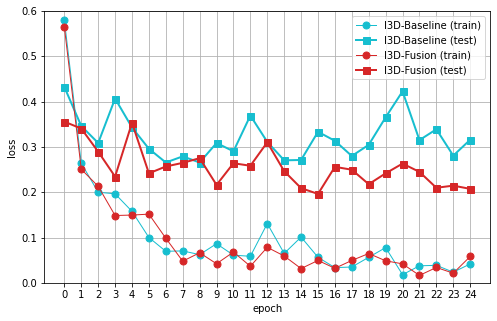

In [31]:
fig, axes = plt.subplots(1,1, figsize=(8,5))
axes.grid(True)
color_dict = {"MR": "tab:cyan", "MR+clinical": "tab:red"}
lws = [1, 2] # (train, test)

for i, use_clinical_data in enumerate([False, True]):
    _name, _hist_loss, _hist_auc = read_history_file(use_clinical_data)
    if _name == "I3ResNet_MR":
        new_name = f"I3D-Baseline"
    elif _name == "I3ResNet_MR+clinical":
        new_name = f"I3D-Fusion"
    _hist_loss = _hist_loss.rename(columns={"train": f"{new_name} (train)", "val": f"{new_name} (test)"})
    _hist_auc = _hist_auc.rename(columns={"train": f"{new_name} (train)", "val": f"{new_name} (test)"})
    _color = color_dict.get(_name.split("_")[-1])
    
    _hist_auc = _hist_auc.apply(lambda x: 1-x)
    ax2 = _hist_auc.plot(style=["o-", "s-"], ax=axes, color=_color, markersize=7)
    for i, l in enumerate(ax2.lines[-2:]):
        plt.setp(l, linewidth=lws[i])
    ax2.set_xticks(range(N_EP))
    ax2.set_xlabel("epoch", fontsize=10)
    ax2.set_ylabel("loss", fontsize=10)

plt.legend(loc="upper right")
plt.grid(True)    
plt.ylim(bottom=0.0, top=0.6)
plt.savefig(f"history_comparison_{ARCH}.png", dpi=300, bbox_inches='tight')

# ROC comparison

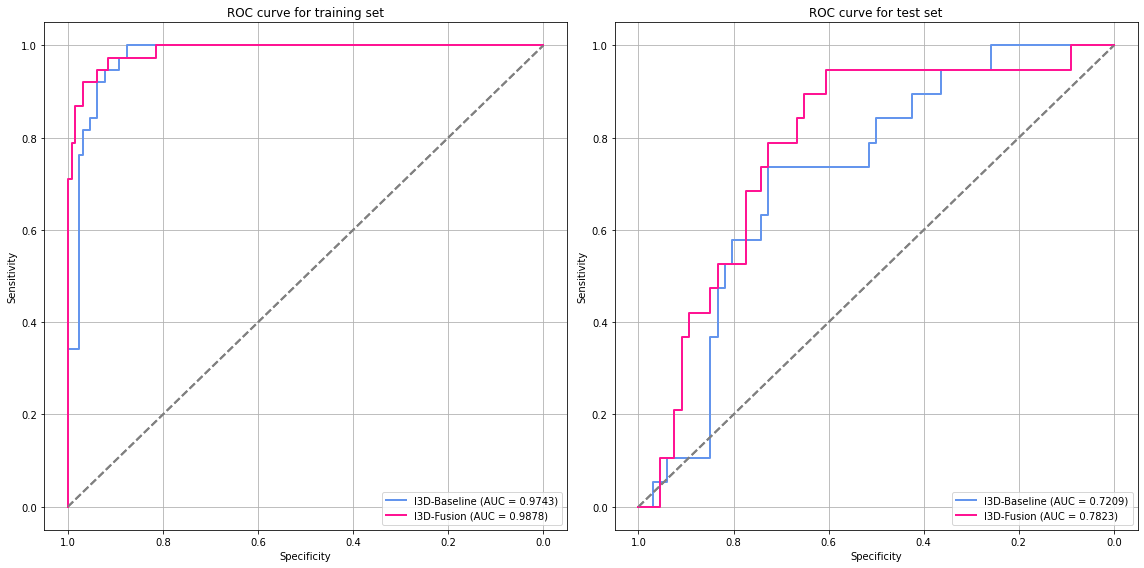

In [32]:
point_colors = [ "cornflowerblue", "deeppink"]

fig, axes = plt.subplots(1,2, figsize=(16,8))

for i, use_clinical_data in enumerate([False, True]):
    _name, _train_results, _test_results = read_evaluation_file(use_clinical_data)
    
    if _name == "I3ResNet_MR":
        _name = f"I3D-Baseline"
    elif _name == "I3ResNet_MR+clinical":
        _name = f"I3D-Fusion"

    # train
    draw_roc(_train_results, legend=_name, point_color=point_colors[i], ax=axes[0],
             title="ROC curve for training set")
    
    # test
    draw_roc(_test_results, legend=_name, point_color=point_colors[i], ax=axes[1],
            title="ROC curve for test set")
plt.savefig(f"roc_comparison_{ARCH}.png", dpi=300)

# Find optimal cut-off value using Youden’s J statistic.
- J statistics is calculated as:
    - J = tpr - fpr
- Optimal threshold is found at a point with maximum J statistics value in ROC curve

In [33]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score, recall_score, precision_score, accuracy_score, balanced_accuracy_score

def to_labels(y_score, t):
    return (y_score>=t).astype(int)

color_map = {
    'I3D-Baseline': point_colors[0],
    'I3D-Fusion': point_colors[1],
}

def measure_performace(eval_data, plot_roc = False, model_name=None):
    fpr, tpr, thresholds = roc_curve(eval_data["y_test"], eval_data["y_score"])

    # J statistic
    J = tpr - fpr
    ix = np.argmax(J)

    if plot_roc:
        c = color_map[model_name]
        # plot the roc curve for the model
        plt.plot([1, 0], [0, 1], color='gray', lw=2, linestyle='--')
        plt.plot(1-fpr, tpr, marker='.', color=c, label=model_name)
        plt.scatter((1-fpr[ix]), tpr[ix], marker='*', color=c, label=f'Best ({model_name})', s=300)
        
        plt.xlim([1.05, -0.05])
        plt.ylim([-0.05, 1.05])
        
        # axis labels
        plt.xlabel('Specificity')
        plt.ylabel('Sensitivity')
        plt.grid(True)
        plt.legend()

    targets = eval_data["y_test"]    
    y_hat = to_labels(eval_data["y_score"], thresholds[ix])
    
    acc = accuracy_score(targets, y_hat)
    bal_acc = balanced_accuracy_score(targets, y_hat)
    sens = recall_score(targets, y_hat)
    spec = recall_score(targets, y_hat, pos_label=0)
    ppv = precision_score(targets, y_hat)
    npv = precision_score(targets, y_hat, pos_label=0)
    f1 = f1_score(targets, y_hat)
    auc_val = auc(fpr, tpr)
    print(f"""
    - Accuracy(overal)={acc}
    - Accuracy(balanced)={bal_acc}
    - Sens={sens}
    - Spec={spec}
    - PPV={ppv}
    - NPV={npv}
    - F1={f1}
    - AUC={auc_val}
    """)
    
    # compute confusion matrix array
    cm_array = confusion_matrix(targets, y_hat).astype(int)
    
    return cm_array

Baseline performance

    - Accuracy(overal)=0.7294117647058823
    - Accuracy(balanced)=0.7320574162679425
    - Sens=0.7368421052631579
    - Spec=0.7272727272727273
    - PPV=0.4375
    - NPV=0.9056603773584906
    - F1=0.5490196078431372
    - AUC=0.7208931419457736
    
Fusion performance

    - Accuracy(overal)=0.6823529411764706
    - Accuracy(balanced)=0.7767145135566188
    - Sens=0.9473684210526315
    - Spec=0.6060606060606061
    - PPV=0.4090909090909091
    - NPV=0.975609756097561
    - F1=0.5714285714285715
    - AUC=0.7822966507177033
    


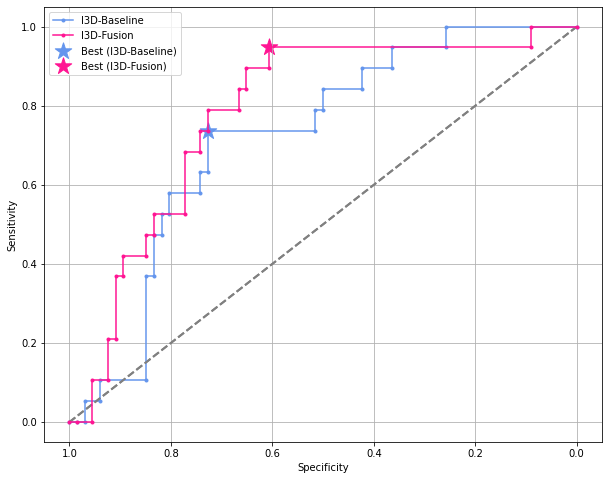

In [34]:
baseline_results = pd.read_csv("results/I3ResNet_MR/test_eval_results_R50.csv")
fusion_results = pd.read_csv("results/I3ResNet_MR+clinical/test_eval_results_R50.csv")

plt.figure(figsize=(10, 8))

print("Baseline performance")
cm_baseline = measure_performace(baseline_results, plot_roc=True, model_name='I3D-Baseline')

print("Fusion performance")
cm_fusion = measure_performace(fusion_results, plot_roc=True, model_name='I3D-Fusion')

## Confusion Matrix

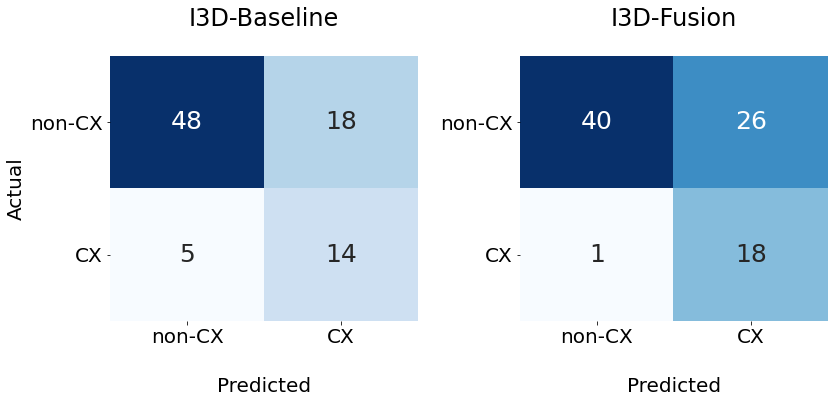

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(1,2, figsize=(12,6))

for ix, array in enumerate([ cm_baseline, cm_fusion]):
    df_cm = pd.DataFrame(array, index=[ i for i in ["non-CX", "CX"]], columns=[ i for i in ["non-CX", "CX"]])
    g = sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues", cbar=False, annot_kws={'size':25}, ax=axes[ix])
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 20)
    g.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 20)
    g.set_xlabel("Predicted", labelpad=30)
    title = "I3D-Baseline" if ix==0 else "I3D-Fusion"
    g.set_title(title, pad=30)
    if ix == 0:
        g.set_ylabel("Actual")
plt.tight_layout()
plt.savefig("DL_confusion_matrix.png", dpi=300, bbox_inches="tight")

## Uncertainty of Models
- We evaluate model's uncertainty using Brier Score
- Brier Score is an evaluation metric used to measure the accuracy of predicted probabilities in binary classification problems defined as:
$$
Brier Score = \frac{1}{N}\sum_{i=1}^{N}(f_i - o_i)^2
$$
where,
($N$) is the total number of samples.
($f_i$) is the predicted probability for the i-th sample.
($o_i$) is the actual result (0 or 1) for the i-th sample.

- As such, Brier Score is a way to measure uncertainty, which relates to how "confident" a model is in its predictions. 
- A low Brier Score (i.e., close to zero) indicates that the model's predicted probabilities are in good agreement with the actual outcome, so you can conclude that the uncertainty is low.

                     BS
HCR (MR only)  0.246299
HCR (MR+cf)    0.250502
DLR (MR only)  0.214661
DLR (MR+cf)    0.193770


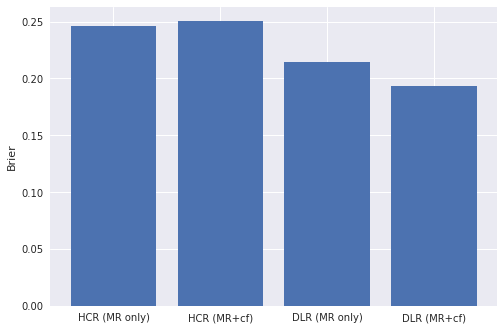

In [36]:
test_eval_results_Baseline = pd.read_csv(f"./results/I3ResNet_MR/test_eval_results_{ARCH}.csv")
test_eval_results_Fusion = pd.read_csv(f"./results/I3ResNet_MR+clinical/test_eval_results_{ARCH}.csv")

test_eval_results_SVC = pd.read_csv(f"./results/SVC_MR/test_eval_results.csv")
test_eval_results_SVC_cf = pd.read_csv(f"./results/SVC_MR+clinical/test_eval_results.csv")

y_test = test_eval_results_Baseline['y_test']

# sample weight to prevent negative-class biased results
class_weight = get_class_weight(dataloaders['train'].dataset)
sample_weight = [ class_weight[class_idx] for class_idx in  y_test ] 

# Brier Score to estimate uncertainty of probability
brier_score_Baseline = metrics.brier_score_loss(y_test, test_eval_results_Baseline['y_score'], sample_weight=sample_weight)
brier_score_Fusion = metrics.brier_score_loss(y_test, test_eval_results_Fusion['y_score'], sample_weight=sample_weight)
brier_score_SVC = metrics.brier_score_loss(y_test, test_eval_results_SVC['SVC_prob2'], sample_weight=sample_weight)
brier_score_SVC_cf = metrics.brier_score_loss(y_test, test_eval_results_SVC_cf['SVC_prob2'], sample_weight=sample_weight)

method_names = ["HCR (MR only)", "HCR (MR+cf)", "DLR (MR only)", "DLR (MR+cf)"]

print(pd.Series([brier_score_SVC, brier_score_SVC_cf, brier_score_Baseline, brier_score_Fusion], 
                index=method_names, name='BS').to_frame())

with plt.style.context('seaborn'):
    plt.bar(method_names, [brier_score_SVC, brier_score_SVC_cf, brier_score_Baseline, brier_score_Fusion])
    plt.ylabel("Brier")